# Cryptocurrency price forecasting

## Python packages

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
import joblib

In [4]:
from statsmodels.tsa.stattools import adfuller

## Import databases

In [5]:
# Fetch cryptocurrency data (e.g., Bitcoin)
btc_data = yf.download('BTC-USD', start='2019-01-01', end='2025-01-01')
print(btc_data.head())

[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open      Volume
Ticker          BTC-USD      BTC-USD      BTC-USD      BTC-USD     BTC-USD
Date                                                                      
2019-01-01  3843.520020  3850.913818  3707.231201  3746.713379  4324200990
2019-01-02  3943.409424  3947.981201  3817.409424  3849.216309  5244856836
2019-01-03  3836.741211  3935.685059  3826.222900  3931.048584  4530215219
2019-01-04  3857.717529  3865.934570  3783.853760  3832.040039  4847965467
2019-01-05  3845.194580  3904.903076  3836.900146  3851.973877  5137609824


In [6]:
# Assume you have another dataset, such as S&P 500
sp500_data = yf.download('^GSPC', start='2019-01-01', end='2025-01-01')

[*********************100%***********************]  1 of 1 completed


## Data Processing

In [7]:
# get only level 0 columns
btc_data.columns = btc_data.columns.levels[0]
sp500_data.columns = sp500_data.columns.levels[0]

In [8]:
btc_data.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2019-01-01,3843.520020,3850.913818,3707.231201,3746.713379,4324200990
2019-01-02,3943.409424,3947.981201,3817.409424,3849.216309,5244856836
2019-01-03,3836.741211,3935.685059,3826.222900,3931.048584,4530215219
2019-01-04,3857.717529,3865.934570,3783.853760,3832.040039,4847965467
2019-01-05,3845.194580,3904.903076,3836.900146,3851.973877,5137609824


In [9]:
btc_data.describe()

Price,Close,High,Low,Open,Volume
count,2192.000000,2192.000000,2192.000000,2192.000000,2.192000e+03
mean,31501.407139,32155.585661,30745.767470,31462.483957,3.043984e+10
std,22114.308430,22576.554349,21579.657797,22085.026506,1.908530e+10
min,3399.471680,3427.945557,3391.023682,3401.376465,4.324201e+09
25%,10581.344727,10776.521973,10311.956543,10577.423828,1.788499e+10
50%,27334.937500,27820.822266,26865.267578,27301.943359,2.673177e+10
75%,46454.189453,47511.051758,45238.041016,46423.242188,3.775100e+10
max,106140.601562,108268.445312,105291.734375,106147.296875,3.509679e+11


In [10]:
# Count missing values in each column
print(btc_data.isnull().sum()) 

Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

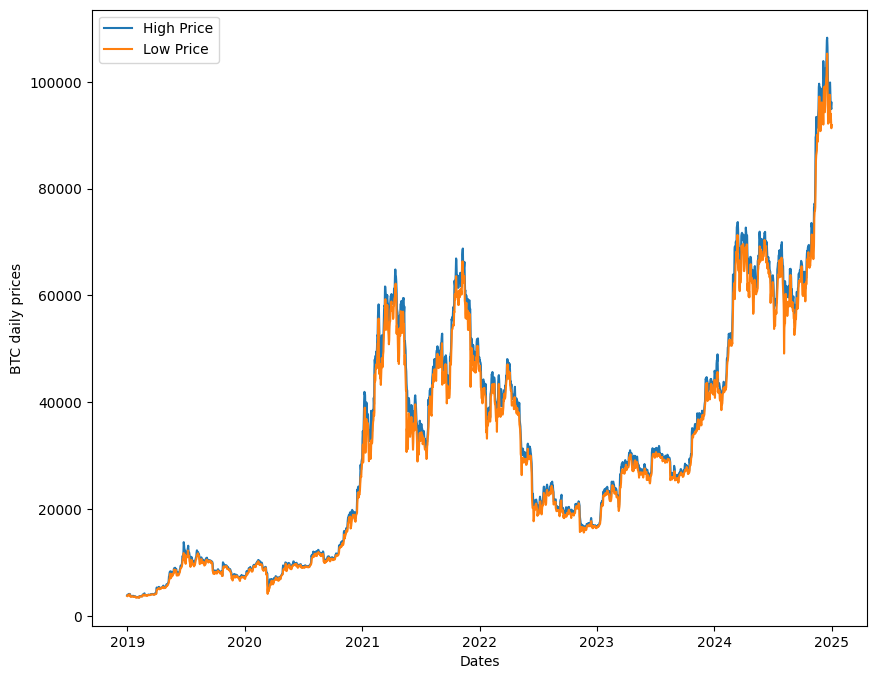

In [11]:
# print BTC highest and closing price 
plt.figure(figsize=(10,8))
plt.plot(btc_data["High"], label='High Price')
plt.plot(btc_data["Low"], label='Low Price')
plt.xlabel("Dates")
plt.ylabel("BTC daily prices")
plt.legend()
plt.show



In [12]:
# compute simple moving average (SMA) for 50 and 200 days to get a sense of the long & short term BTC trends. 
btc_data['SMA50'] = btc_data['Close'].rolling(window=50).mean()
btc_data['SMA200'] = btc_data['Close'].rolling(window=200).mean()

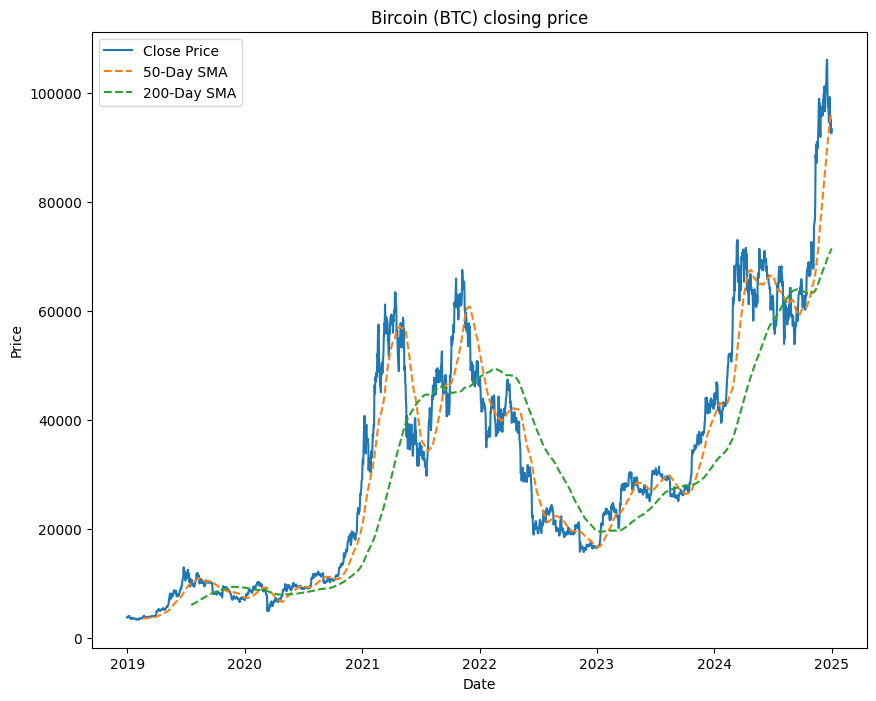

In [13]:
plt.figure(figsize=((10,8)))
plt.plot(btc_data["Close"], label='Close Price')
plt.plot(btc_data["SMA50"], label='50-Day SMA', linestyle='--')
plt.plot(btc_data["SMA200"], label='200-Day SMA', linestyle='--')
plt.title("Bircoin (BTC) closing price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

#### Check the stationarity of BTC price using ADF test

### Add S&P 500 stock market index

In [19]:
sp500_data.head(10)

Price,Close,High,Low,Open,Volume
Date,,,,,
2019-01-02,2510.030029,2519.489990,2467.469971,2476.959961,3733160000
2019-01-03,2447.889893,2493.139893,2443.959961,2491.919922,3858830000
2019-01-04,2531.939941,2538.070068,2474.330078,2474.330078,4234140000
2019-01-07,2549.689941,2566.159912,2524.560059,2535.610107,4133120000
2019-01-08,2574.409912,2579.820068,2547.560059,2568.110107,4120060000
2019-01-09,2584.959961,2595.320068,2568.889893,2580.000000,4088740000
2019-01-10,2596.639893,2597.820068,2562.020020,2573.510010,3721300000
2019-01-11,2596.260010,2596.270020,2577.399902,2588.110107,3447460000
2019-01-14,2582.610107,2589.320068,2570.409912,2580.310059,3689370000


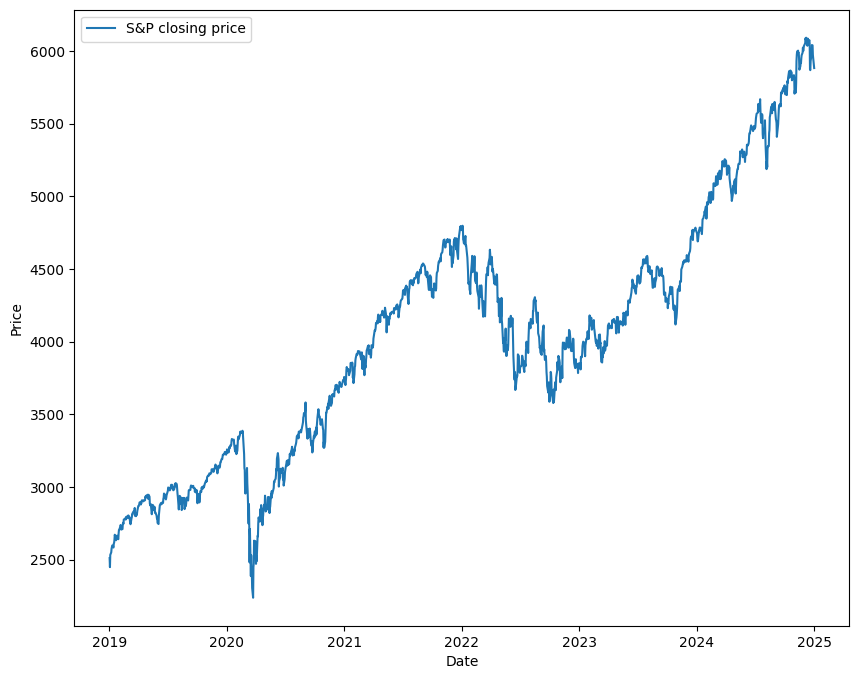

In [20]:
plt.figure(figsize=(10,8))
#plt.plot(merged_data["Close_BTC"], label = "BTC closing price")
plt.plot(sp500_data["Close"], label = "S&P closing price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [21]:
# merge sp500_data with btc_data
merged_data  = pd.merge(btc_data, sp500_data, left_index = True, right_index = True, suffixes=('_BTC', '_S&P500'))

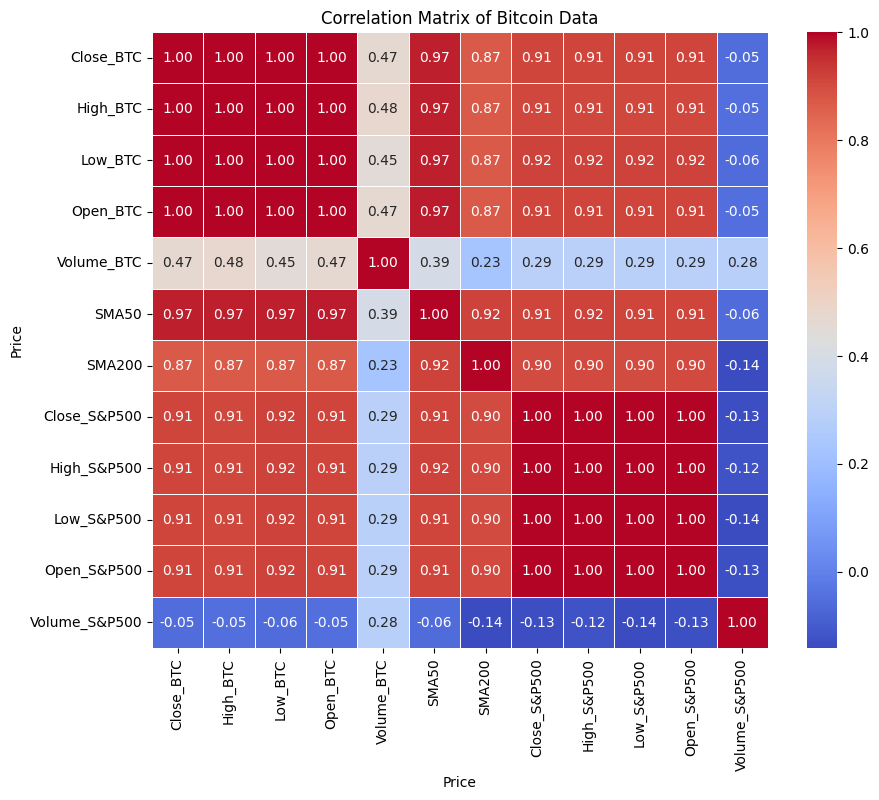

In [22]:
# compute correlation matrix
matrix_corr = merged_data.corr()

# plot correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(matrix_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True)
# Display the plot
plt.title("Correlation Matrix of Bitcoin Data")
plt.show()

Based on the correlation matrix, the BTC and S&P 500 closing prices are correlated. Suggesting that we should include both in the prediction model.

In [23]:
# for prediction, we will only keep BTC and S&P 500 closing prices
merged_data = merged_data[["Close_BTC", "Close_S&P500"]]

### Split the Data into Training and Test Sets

In [104]:
# Split data into train and test sets (80% train, 20% test)
# train_size = int(len(merged_data) * 0.8)
train_size = int(len(merged_data) * 0.5)

data_train, data_test = merged_data[:train_size], merged_data[train_size:]

In [105]:
# index of data test
data_test_index = data_test.index

## ARIMA and XARIMA model

ARIMA is an efficient model used for time series forcasting. It combines 3 components : 
#### 1- AutoRegressive (AR) part :
 It models the relationship between the current observation and the previous ones: It assumes that the current observation of the series is a linear function of its previous values. The number of lagged observations is represented by the parameter p (also called the order of the autoregressive part).


$$
y_t = \mu + \sum_{i=1}^{p} \phi_i y_{t-i} + \varepsilon_t
$$

Where:
- $ y_t $ is the value of the series at time t,
- $ \mu $ is the constant or mean of the time series,
- $ \phi_i $ are the coefficients of the AR part (autoregressive coefficients),
- $ y_{t-i} $ are the previous observations (lags) of the time series,
- $ \varepsilon_t $ is the error term at time t (white noise).

#### Differencing or Integration (I) part : 
This part of the ARIMA model aims at differencing the time series to make it stationary. A stationary time series have constant statistical properties, such as mean and variance over time. Many real-world time series have trends or seasonal patterns, making them non-stationary. The idea of this step is to remove the trends of the time series by substracting previous values from the current ones. This step could be repeated one or more times until the series become stationary. The order of differencing is noted as d which corresponds to the number of times the differencing was applied.


$$
\Delta y_t = y_t - y_{t-1}
$$

Where:
- $ \Delta y_t $ represents the first difference of the time series,
- $ y_t $ is the current observation at time t,
- $ y_{t-1} $ is the observation at time t-1.

#### Moving average (MA):
The MA part of ARIMA is used to model the error term as a linear combination of the previous errors. In other words, it looks at how the past forcasting errors influence the current value of the series. 
The general form of a moving average model of order q (MA(q)) is:

$$
y_t = \mu + \varepsilon_t + \sum_{i=1}^{q} \theta_i \varepsilon_{t-i}
$$

Where:
- $ y_t $ is the observed value at time $ t $,
- $ \mu $ is a constant (mean),
- $ \varepsilon_t $ is the error term (residual) at time $ t $,
- $ \theta_i $ are the coefficients of the MA part (moving average coefficients),
- $ \varepsilon_{t-i} $ are the past errors (residuals).


### Full ARIMA(p, d, q) Model

Combining all three parts (AR, I, and MA), the **ARIMA(p, d, q)** model is represented as:

$$
\Delta^d y_t = \mu + \sum_{i=1}^{p} \phi_i \Delta^d y_{t-i} + \sum_{j=1}^{q} \theta_j \varepsilon_{t-j} + \varepsilon_t
$$

Where:
- $ \Delta^d y_t $ is the differenced series (after differencing the time series \( d \) times),
- $ \mu $ is the constant (mean),
- $ \phi_i $ are the AR coefficients (AutoRegressive terms),
- $ \varepsilon_t $ is the error term (white noise),
- $ \theta_j $ are the coefficients of the MA part (Moving Average terms),
- $ p $ is the number of autoregressive terms (lags),
- $ q $ is the number of moving average terms (lags),
- $ d $ is the degree of differencing applied to make the series stationary.

##### Check the stationarity of the model 

Before applying the ARIMA model, we need to check whether the price is stationary or not. For that, we are going to use 2 approaches. The first one is to plot the prices over time and the second approach is to use ADF (Augmented Dickey-Fuller) test.
To use the ADF test, we need to set up the null hypothesis (H0) in which we assume that the data is not stationary. If the p-value is less than 0.05, the (H0) is rejected, meaning the series is stationary.



<function matplotlib.pyplot.show(close=None, block=None)>

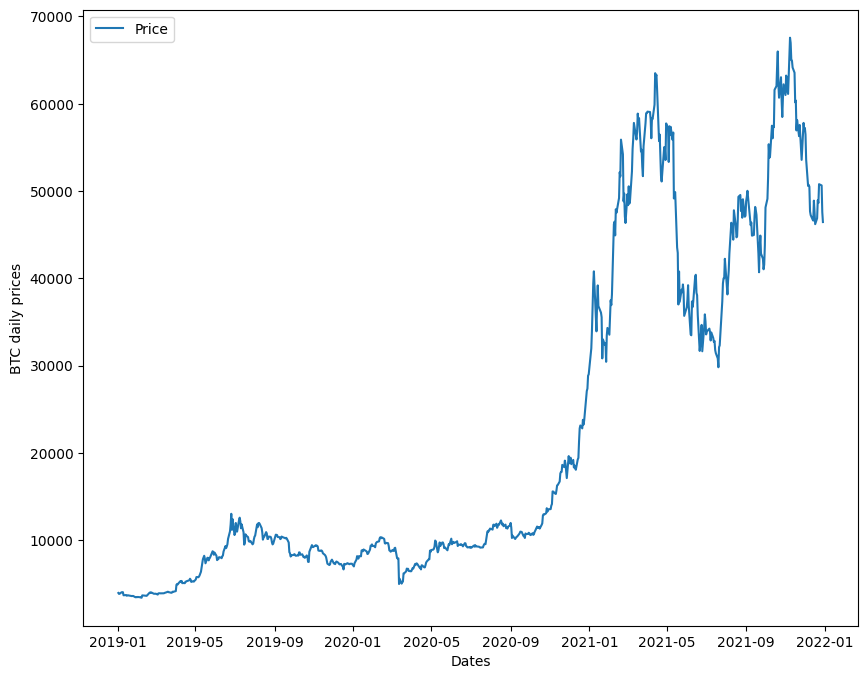

In [106]:
# print BTC prices
plt.figure(figsize=(10,8))
plt.plot(data_train["Close_BTC"], label='Price')
plt.xlabel("Dates")
plt.ylabel("BTC daily prices")
plt.legend()
plt.show

In [107]:
# Perform ADF test to check for stationarity
result = adfuller(data_train['Close_BTC'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary. Consider differencing.")

ADF Statistic: -0.8132161119129775
p-value: 0.8152090759828956
The series is non-stationary. Consider differencing.


From both approaches, we figure out that the data is not stationary. We need to use differencing approach which consists in substracting the previous values from the current ones.  

In [112]:
data_diff_train = data_train.diff().dropna()  # First differencing

data_diff_train = data_diff_train.diff().dropna()  # First differencing

data_diff_train = data_diff_train.diff().dropna()  # First differencing

data_diff_train = data_diff_train.diff().dropna()  # First differencing

Let's again check the stationarity of the model 

<function matplotlib.pyplot.show(close=None, block=None)>

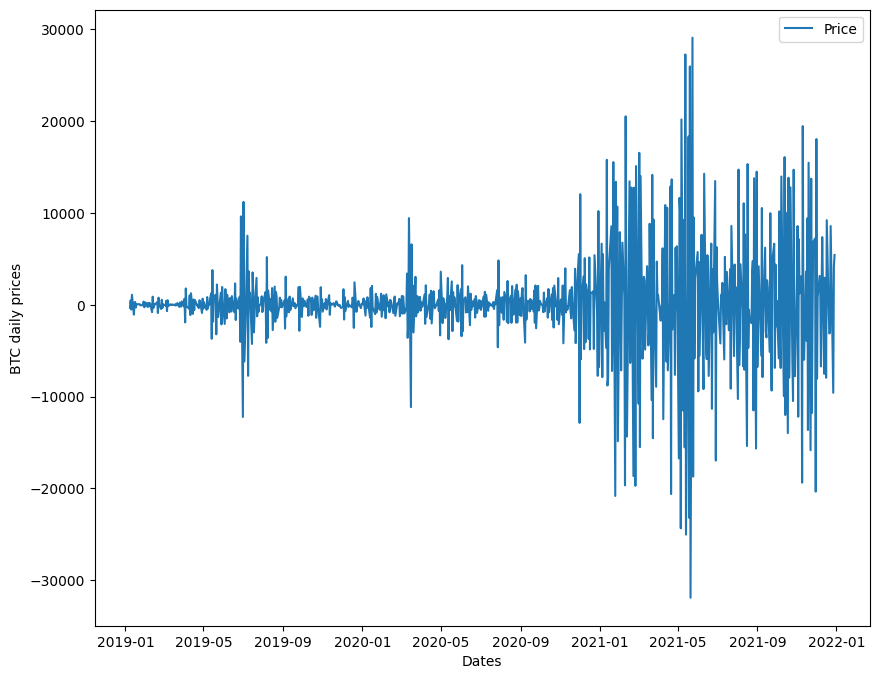

In [113]:
# print BTC prices 
plt.figure(figsize=(10,8))
plt.plot(data_diff_train["Close_BTC"], label='Price')
plt.xlabel("Dates")
plt.ylabel("BTC daily prices")
plt.legend()
plt.show

In [114]:
# Perform ADF test to check for stationarity
result = adfuller(data_diff_train['Close_BTC'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary. Consider differencing.")

ADF Statistic: -14.997473228171406
p-value: 1.1022594781181344e-27
The series is stationary.


Great, our series is stationary. The order of differencing is d = 1. 

Once our series is stationary, we are going to define the order of the AutoRegressive (AR) part (p) which represents how much the past values are influencing the current value. To find the optimal value of p, we are going to use ACF (AutoCorrelation fucntion) and PACF (Partial autoCorrelation function)

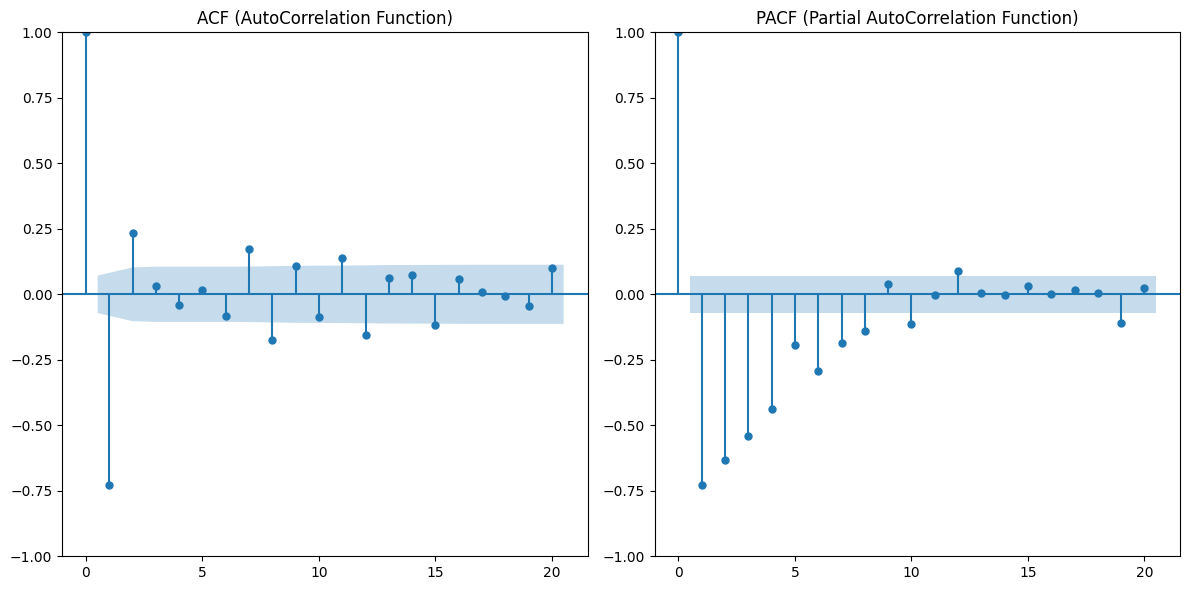

In [115]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(data_diff_train['Close_BTC'], lags=20, ax=plt.gca())
plt.title('ACF (AutoCorrelation Function)')

plt.subplot(122)
plot_pacf(data_diff_train['Close_BTC'], lags=20, ax=plt.gca())
plt.title('PACF (Partial AutoCorrelation Function)')
plt.tight_layout()
plt.show()

- ACF plot is used to determine the q parameter (MA component). It shows the correlaction between the current value of the time series and residual (errors) from the past q observations.
- PACF plot is used to determine the p parameter (AR component). It suggests that only p previous values influence the current value.  

Based on the ACF and PACF plots, we find that the autocorrelation function cuts off after lag 1 so p=1 and the partial autocorrelation function cuts off after lag =1 so q = 1. This means that there is a strong correlation between $Y_{t}$ and $Y_{i-1}$. This suggests that the current value in the time series is only significantly influenced by the immediate previous value and not by values further in the past. 

1- Fit the ARIMA Model

In [116]:
(p, d, q) = (10, 1, 10)
# Fit the ARIMA model with the identified p, d, q values
model = ARIMA(data_diff_train[["Close_BTC"]], order=(p, d, q))
model_fit = model.fit()

# Print the summary of the model
print(model_fit.summary())

c:\Users\anass\Documents\github\cryptocurrency-price-forecasting\cryptovenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\anass\Documents\github\cryptocurrency-price-forecasting\cryptovenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\anass\Documents\github\cryptocurrency-price-forecasting\cryptovenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\anass\Documents\github\cryptocurrency-price-forecasting\cryptovenv\Lib\site-pac

                               SARIMAX Results                                
Dep. Variable:              Close_BTC   No. Observations:                  751
Model:               ARIMA(10, 1, 10)   Log Likelihood               -6569.942
Date:                Sat, 18 Jan 2025   AIC                          13181.885
Time:                        20:46:27   BIC                          13278.906
Sample:                             0   HQIC                         13219.269
                                - 751                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -4.5053      0.078    -57.586      0.000      -4.659      -4.352
ar.L2        -10.7090      0.319    -33.573      0.000     -11.334     -10.084
ar.L3        -17.6504      0.713    -24.761      0.0

2- Model Diagnostics (Check Residuals)

Once we fitted the model, it's important to check the residuals of the models (errors of the model). They should ideally resemble white noise (they should have no pattern or autocorrelation). If they are still correlated, this suggests that the models has not fully captured the underlying patterns in the data

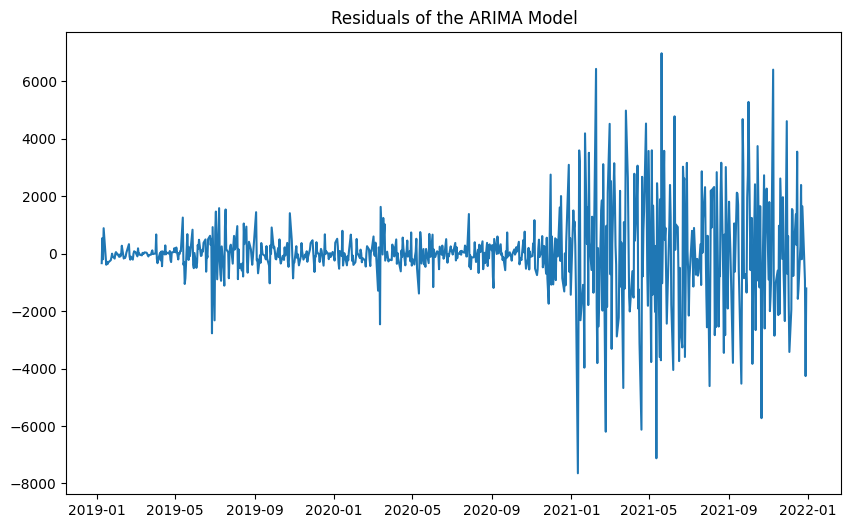

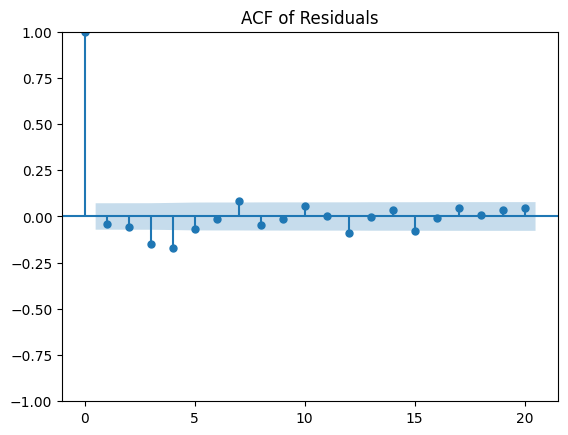

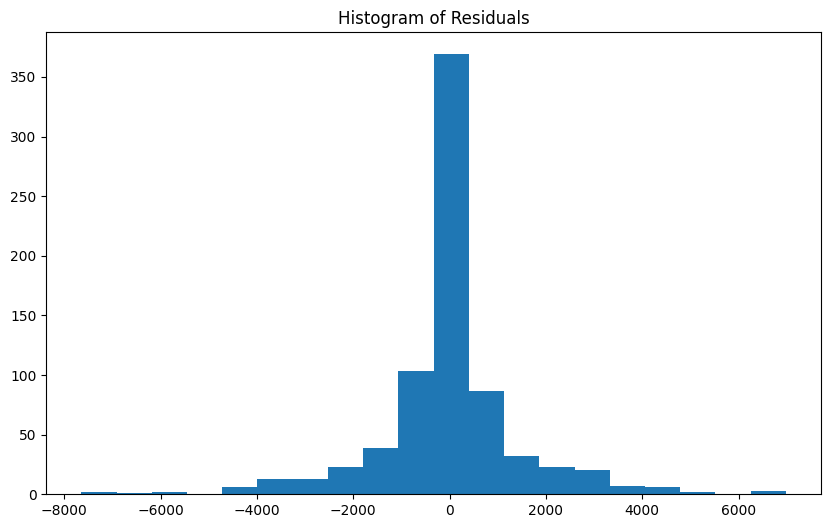

In [117]:
# Get residuals from the model
residuals = model_fit.resid

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of the ARIMA Model')
plt.show()

# Plot the ACF of residuals to check for autocorrelation
plot_acf(residuals, lags=20)
plt.title('ACF of Residuals')
plt.show()

# Plot histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20)
plt.title('Histogram of Residuals')
plt.show()

3- Forecasting

c:\Users\anass\Documents\github\cryptocurrency-price-forecasting\cryptovenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\anass\Documents\github\cryptocurrency-price-forecasting\cryptovenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecasted values (original scale): 754    -1514.472936
755     -755.706253
756    -1073.886276
757     -806.293485
758    -1166.555539
           ...     
1504   -1088.129880
1505   -1088.498184
1506   -1087.991155
1507   -1088.165346
1508   -1088.478727
Name: predicted_mean, Length: 755, dtype: float64


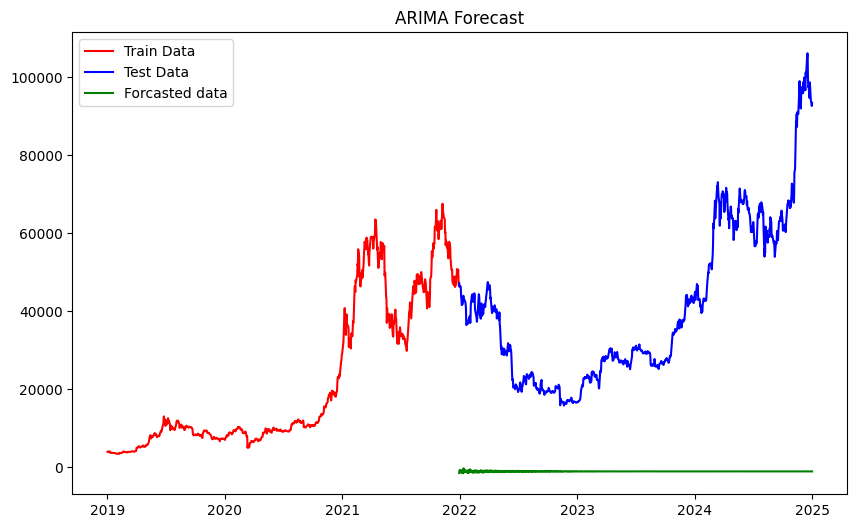

In [99]:
# Forecast the next 10 time points (adjust number of steps as needed)
forecast_steps = len(data_test)
forecast = model_fit.forecast(steps=forecast_steps)

# Assuming the last value of your original data is 'last_value'
last_value = data_diff_train["Close_BTC"].iloc[-1]

# Inverse Differencing: Add the forecasted values to the last observed value to get the values in the original scale 
forecast_original_scale = forecast + last_value
print("Forecasted values (original scale):", forecast_original_scale)

# set test index to forcasted data
forecast_original_scale.index = data_test.index

# Print the forecasted values
#print("Forecasted values:", forecast)

# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(data_train["Close_BTC"], label='Train Data', color='red')  # Plot the train data
plt.plot(data_test["Close_BTC"], label='Test Data', color='blue')  # Plot the test data
plt.plot(forecast_original_scale, label='Forcasted data', color='green')  # Plot the predicted data
plt.legend()
plt.title('ARIMA Forecast')
plt.show()

5- Model evaluation

In [ ]:
# Calculate MSE and RMSE
mse = mean_squared_error(y_test_actual, forecast_original_scale)
rmse = math.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(y_test_actual, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')

## SLTM model

### Normalize the Data

In [19]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale both Bitcoin and S&P 500 data (since we now have two features)
data_train_norm = scaler.fit_transform(data_train)

# Scale both Bitcoin and S&P 500 data (since we now have two features)
data_test_norm = scaler.transform(data_test)

# Check the scaled data
data_test_norm[:5]

array([[0.39459838, 0.797371  ],
       [0.40960823, 0.77633291],
       [0.46264587, 0.7735507 ],
       [0.4753516 , 0.78552343],
       [0.4847223 , 0.7617226 ]])

### Create Sequences with Both Bitcoin and S&P 500 Data

Now that we have both features (Bitcoin and S&P 500) closing prices, we’ll create input sequences for LSTM, using both features as the input variables.

In [20]:
n_steps_ahead_value = 1
# Function to create sequences using both Bitcoin and S&P 500 data
def create_sequences_multivariate(data_in, time_step=6, n_steps_ahead=n_steps_ahead_value):
    """ 
    This function reshapes data_in to be 3D as expected by LSTM (samples, time steps, features)
    """
    X_out = []
    y_out = []
    for i in range(time_step, len(data_in)-n_steps_ahead + 1):
        X_out.append(data_in[i-time_step:i, :])  # Take the previous `time_step` data as input (both Bitcoin and S&P 500)
        y_out.append(data_in[i:i+n_steps_ahead, 0])  # Predict the next n_steps_ahead Bitcoin price
    return np.array(X_out), np.array(y_out)



In [21]:
data_train

Price,Close_BTC,Close_S&P500
Date,,
2019-01-02,3943.409424,2510.030029
2019-01-03,3836.741211,2447.889893
2019-01-04,3857.717529,2531.939941
2019-01-07,4025.248291,2549.689941
2019-01-08,4030.847900,2574.409912
...,...,...
2023-10-12,26756.798828,4349.609863
2023-10-13,26862.375000,4327.779785
2023-10-16,28519.466797,4373.629883


In [22]:
# Create sequences with the train data (including both Bitcoin and S&P 500 features)
X_train, y_train = create_sequences_multivariate(data_train_norm, n_steps_ahead=n_steps_ahead_value)

# Create sequences with the test data (including both Bitcoin and S&P 500 features)
X_test, y_test = create_sequences_multivariate(data_test_norm, n_steps_ahead=n_steps_ahead_value)


# Check the shape of the input data
print("Train's shapes : ", X_train.shape, y_train.shape)

# Check the shape of the input data
print("Test's shapes : ", X_test.shape, y_test.shape)


Train's shapes :  (1202, 6, 2) (1202, 1)
Test's shapes :  (296, 6, 2) (296, 1)


### Define the LSTM model

Now, we will define the LSTM model, which will take as inputs S&P500 and BTC closing prices.

In [23]:
# Define the LSTM model
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))

# Add Dropout to prevent overfitting
model.add(Dropout(0.2))

# Add a Dense output layer
model.add(Dense(units=n_steps_ahead_value))  # Predict the next Bitcoin price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()


c:\Users\anass\Documents\github\cryptocurrency-price-forecasting\cryptovenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6, 50)          │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,851 (120.51 KB)

 Trainable params: 30,851 (120.51 KB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

Now, can train our LSTM model with both BTC and S&P500 closing pice

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 0.0714 - val_loss: 0.0111
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - val_loss: 0.0085
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 0.0040
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - val_loss: 0.0054
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - val_loss: 0.0084
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - val_

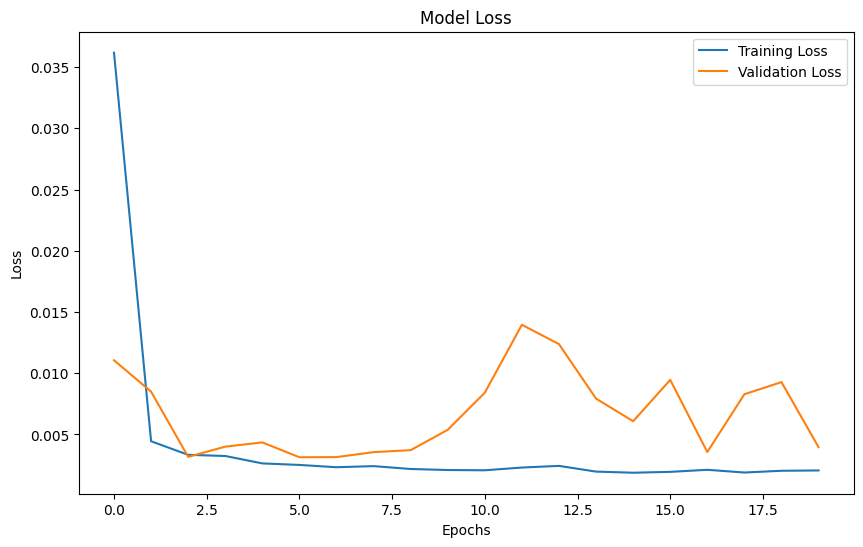

In [24]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Plot the training and validation loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Make Predictions

In [25]:
# Make predictions on the test data
predictions = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


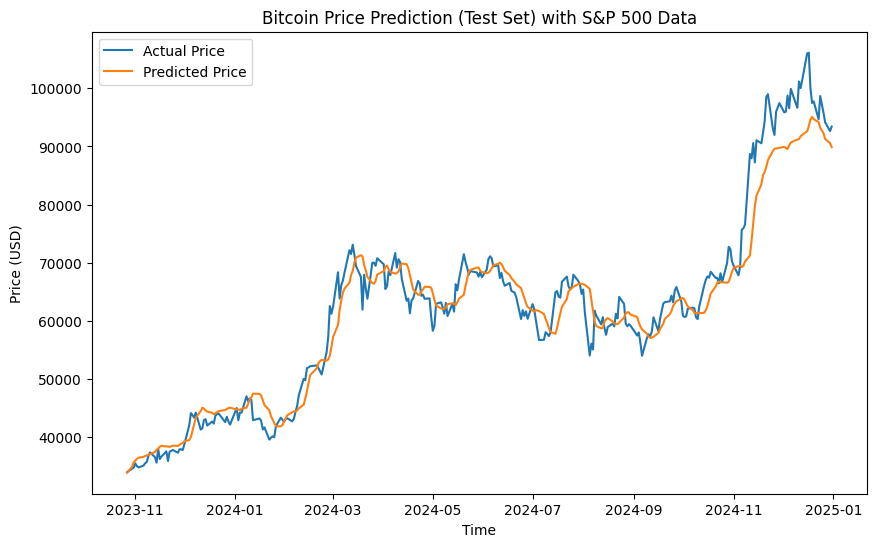

In [26]:
# Inverse transform the predictions and actual values to get the actual Bitcoin price scale
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], 1))), axis=1))[:,0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:,0]

# Plot the actual vs predicted prices
plt.figure(figsize=(10,6))
plt.plot(data_test_index[-len(predictions):], y_test_actual, label='Actual Price')
plt.plot(data_test_index[-len(predictions):], predictions, label='Predicted Price')
plt.title("Bitcoin Price Prediction (Test Set) with S&P 500 Data")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

### Evaluate the Model

For model evaluation, we are going to use mean squared error, root mean squared error and mean absolute error

In [27]:
# Calculate MSE and RMSE
mse = mean_squared_error(y_test_actual, predictions)
rmse = math.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(y_test_actual, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 16298265.992144436
Root Mean Squared Error: 4037.1110948479527
Mean Absolute Error: 2909.4416352810676


## Prophet model

In [118]:
# reset index of train data
data_train.reset_index(inplace = True)

# reset index of test data
data_test.reset_index(inplace = True)

In [119]:
# rename train's columns
data_train.rename(columns={'Date':'ds', 'Close_BTC':'y'}, inplace = True)

# rename test's columns
data_test.rename(columns={'Date':'ds', 'Close_BTC':'y'}, inplace = True)

C:\Users\anass\AppData\Local\Temp\ipykernel_656\3644670627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train.rename(columns={'Date':'ds', 'Close_BTC':'y'}, inplace = True)
C:\Users\anass\AppData\Local\Temp\ipykernel_656\3644670627.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.rename(columns={'Date':'ds', 'Close_BTC':'y'}, inplace = True)


In [120]:
# Initialize the Prophet model
prophet_model = Prophet()

# Add the S&P500 data as an additional regressor to improve predictions
prophet_model.add_regressor('Close_S&P500')

# Fit the model on the merged data
prophet_model.fit(data_train)

# Step 4: Make future predictions
# Create a DataFrame with future dates for prediction
#future_dates = prophet_model.make_future_dataframe(data_train, periods=len(data_test))  # Predict for 365 days ahead


23:20:46 - cmdstanpy - INFO - Chain [1] start processing
23:20:49 - cmdstanpy - INFO - Chain [1] done processing


- save Prophet model

In [23]:
# Save the trained model to a file using joblib
#joblib.dump(prophet_model, 'prophet_model.joblib')

print("Model saved successfully!")

Model saved successfully!


In [140]:
# Load the saved Prophet model
#prophet_model_loaded = joblib.load('prophet_model.joblib')

In [24]:
# Predict future values
forecast = prophet_model.predict(data_test[['ds', 'Close_S&P500']])

In [25]:
# Extract the forecasted values and dates
forecasted_values = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [26]:
forecasted_values

,ds,yhat,yhat_lower,yhat_upper
0,2021-12-30,58390.379398,52717.055650,64166.413662
1,2021-12-31,59021.575509,52870.298174,65162.070287
2,2022-01-03,61147.540319,55552.925979,67159.512009
3,2022-01-04,61499.253094,55997.209466,67281.441112
4,2022-01-05,61415.574628,55489.460234,67293.022931
...,...,...,...,...
750,2024-12-24,109596.786863,26350.633040,190636.782953
751,2024-12-26,110932.820346,27372.325308,193069.196236
752,2024-12-27,111141.983869,26280.028596,192560.180872
753,2024-12-30,112723.740044,27357.987418,193283.932426


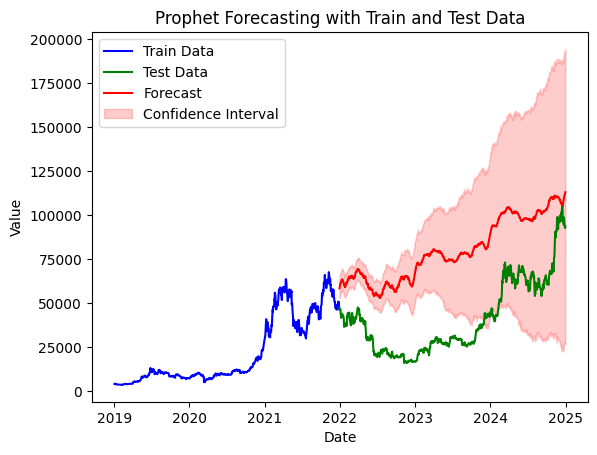

In [34]:
plt.clf()  # Clear the figure before each new plot
# Plot the results
# Clear the previous plot to avoid overlay
plt.plot(data_train['ds'], data_train['y'], label='Train Data', color='blue')
plt.plot(data_test['ds'], data_test['y'], label='Test Data', color='green')
plt.plot(forecasted_values['ds'], forecasted_values['yhat'], label='Forecast', color='red')
plt.fill_between(forecasted_values['ds'], forecasted_values['yhat_lower'], forecasted_values['yhat_upper'], 
                color='red', alpha=0.2, label='Confidence Interval')

plt.title('Prophet Forecasting with Train and Test Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
# Redraw the updated plot
# plt.draw()
# plt.pause(1)   # Pause for a short time to allow for the plot update (1 second in this case)
plt.show()

In [28]:
data_train_base = data_train
data_test_base = data_test

In [29]:
data_train = data_train_base
data_test = data_test_base

In [30]:
data_train.shape, data_test.shape

((755, 3), (755, 3))

In [31]:
import matplotlib
#matplotlib.use('TkAgg')  # or 'Qt5Agg'

In [32]:
def show_prediction(data_train, data_test, forecasted_values, ax, first_time):
    #plt.clf()  # Clear the figure before each new plot
    # Plot the results
    # Clear the previous plot to avoid overlay
    ax.plot(data_train['ds'], data_train['y'], label='Train Data', color='blue')
    ax.plot(data_test['ds'], data_test['y'], label='Test Data', color='green')
    ax.plot(forecasted_values['ds'], forecasted_values['yhat'], label='Forecast', color='red')
    ax.fill_between(forecasted_values['ds'], forecasted_values['yhat_lower'], forecasted_values['yhat_upper'], 
                    color='red', alpha=0.2, label='Confidence Interval')
    if first_time: 
        ax.set_title('Prophet Forecasting with Train and Test Data')
        ax.set_xlabel('Date')
        ax.set_ylabel('Value')
        ax.legend()
    # Redraw the updated plot
    plt.draw()
    plt.pause(1)   # Pause for a short time to allow for the plot update (1 second in this case)
    


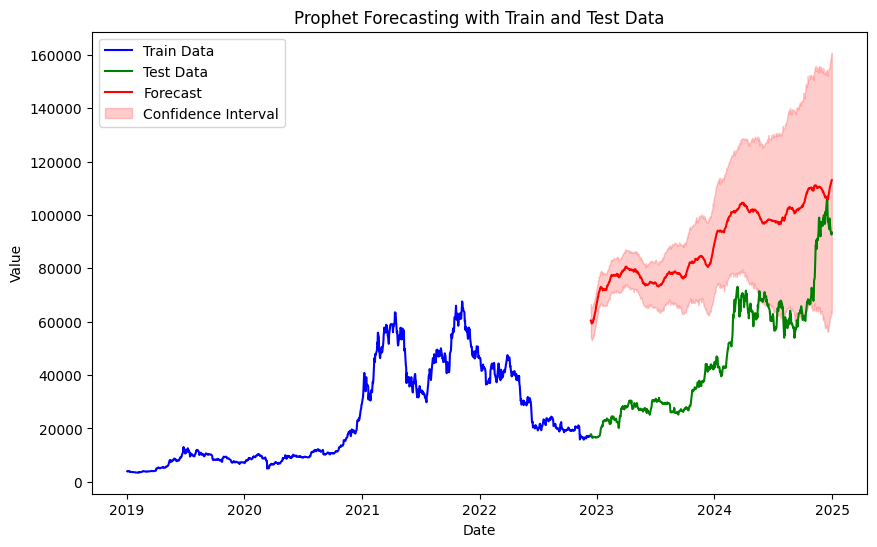

test shape (495, 3)


<Figure size 640x480 with 0 Axes>

test shape (475, 3)


<Figure size 640x480 with 0 Axes>

test shape (455, 3)


<Figure size 640x480 with 0 Axes>

test shape (435, 3)


<Figure size 640x480 with 0 Axes>

test shape (415, 3)


<Figure size 640x480 with 0 Axes>

test shape (395, 3)


<Figure size 640x480 with 0 Axes>

test shape (375, 3)


<Figure size 640x480 with 0 Axes>

test shape (355, 3)


<Figure size 640x480 with 0 Axes>

test shape (335, 3)


<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

In [137]:
# Create the figure and axes outside the loop
fig, ax = plt.subplots(figsize=(10, 6))

# Enable interactive mode
#plt.ion()

show_prediction(data_train, data_test, forecasted_values, ax, True)
while len(data_test)>0:
    #plt.clf() 
    # data_train = pd.concat([data_train, data_test.iloc[[:20]]], axis = 0)
    data_train = pd.concat([data_train, data_test.iloc[:20]], axis = 0)

    data_test = data_test.iloc[20:]
    print(f"test shape {data_test.shape}")
    # Predict future values
    data_forcasting = prophet_model.predict(data_test[['ds', 'Close_S&P500']])

    # Extract the forecasted values and dates
    forecasted_values = data_forcasting[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    show_prediction(data_train, data_test, forecasted_values, ax, False)
    plt.pause(0.5) 

- Real Time BTC price

In [ ]:
import requests

def get_btc_price():
    url = 'https://api.kraken.com/0/public/Ticker?pair=XBTUSD'
    response = requests.get(url)
    data = response.json()
    return data['result']['XXBTZUSD']['c'][0]


for i in range(15):
    # Get real-time BTC price in USD
    btc_price = get_btc_price()
    print(f"Current Bitcoin price: ${btc_price}")
    time.sleep(2)

- Real Time news

In [162]:
import requests

def get_cryptocurrency_news():
    url = "https://cryptopanic.com/api/v1/posts/"
    params = {"auth_token": "7fc43f7898dc44c7b8a6841445915a92", "filter": "bitcoin"}
    response = requests.get(url, params=params)
    return response.json()

news_data = get_cryptocurrency_news()
print(news_data)

{'status': 'Incomplete', 'info': 'Token not found'}


In [163]:
import requests

def get_bitcoin_news(api_key):
    url = "https://newsapi.org/v2/everything"
    params = {
        'q': 'bitcoin',  # search query for bitcoin-related news
        'apiKey': api_key,  # your NewsAPI key
        'language': 'en',  # language filter
        'sortBy': 'publishedAt',  # sort by the most recent
        'pageSize': 5  # number of results per request
    }
    
    response = requests.get(url, params=params)
    news_data = response.json()
    
    if news_data['status'] == 'ok':
        return news_data['articles']
    else:
        return []

# Replace with your actual NewsAPI key
api_key = '7fc43f7898dc44c7b8a6841445915a92'
bitcoin_news = get_bitcoin_news(api_key)

# Print the titles of the fetched Bitcoin-related news
for article in bitcoin_news:
    print(f"Title: {article['title']}")
    print(f"Source: {article['source']['name']}")
    print(f"URL: {article['url']}")
    print(f"Published: {article['publishedAt']}")
    print()

Title: DOJ Says $12 Billion in Bitcoin Stolen in 2016 Hack Should Be Returned to Bitfinex
Source: Decrypt
URL: https://decrypt.co/301112/doj-12-billion-bitcoin-stolen-2016-hack-returned-bitfinex
Published: 2025-01-15T17:18:51Z

Title: Still Learning After All These Years
Source: Biztoc.com
URL: https://biztoc.com/x/38c324729617a638
Published: 2025-01-15T17:08:24Z

Title: U.S. Prosecutors Ask Court to Green-Light Return of 95,000 Stolen Bitcoin to Bitfinex
Source: Biztoc.com
URL: https://biztoc.com/x/ba3af6ed342da1d8
Published: 2025-01-15T17:08:04Z

Title: Robinhood Stock Soars As It Hits Best Financial And Best Crypto Lists
Source: Investor's Business Daily
URL: https://www.investors.com/news/robinhood-stock-best-financial-stock-crypto-stock-lists/
Published: 2025-01-15T17:03:27Z

Title: BlackRock’s quarterly revenue up 23 per cent to nearly US$5.7 billion
Source: Financial Post
URL: https://financialpost.com/investing/blackrocks-quarterly-revenue-up-to-us5-7-billion
Published: 2025-01

In [168]:
url = "https://newsapi.org/v2/everything"
api_key = '7fc43f7898dc44c7b8a6841445915a92'
start_date = "2025-01-15"
end_date = "2025-01-15"

params = {
    'q': 'bitcoin',  # search query for bitcoin-related news
    'apiKey': api_key,  # your NewsAPI key
    'language': 'en',  # language filter
    'sortBy': 'publishedAt',  # sort by the most recent
    'pageSize': 5,  # number of results per request
    'from': start_date,  # start date (YYYY-MM-DD)
    'to': end_date  # end date (YYYY-MM-DD)
}

response = requests.get(url, params=params)
news_data = response.json()

In [169]:
news_data

{'status': 'ok',
 'totalResults': 215,
 'articles': [{'source': {'id': None, 'name': 'newsBTC'},
   'author': 'Scott Matherson',
   'title': 'Bitcoin Traders Turn Bearish Despite Price Recovery Above $97,000, Here Are The Numbers',
   'description': 'The Bitcoin price has recovered above $97,000, providing a bullish outlook for the flagship crypto. Despite this development, BTC traders still look apprehensive as their strategy suggests they are still bearish on the current price action.\xa0 Bitcoin Traders T…',
   'url': 'http://www.newsbtc.com/news/bitcoin/bitcoin-traders-turn-bearish/',
   'urlToImage': 'https://www.newsbtc.com/wp-content/uploads/2024/12/bitcoin_3976f9.jpg?fit=1920%2C1277',
   'publishedAt': '2025-01-15T23:30:32Z',
   'content': 'The Bitcoin price has recovered above $97,000, providing a bullish outlook for the flagship crypto. Despite this development, BTC traders still look apprehensive as their strategy suggests they are s… [+2759 chars]'},
  {'source': {'id': Non

In [164]:
news_data

{'status': 'Incomplete', 'info': 'Token not found'}

Current Bitcoin price: $98367.10000
Current Bitcoin price: $98500.00000
Current Bitcoin price: $98500.00000
Current Bitcoin price: $98500.00000
Current Bitcoin price: $98499.90000
Current Bitcoin price: $98500.00000
Current Bitcoin price: $98500.00000
Current Bitcoin price: $98500.00000
Current Bitcoin price: $98499.90000
Current Bitcoin price: $98499.90000


KeyboardInterrupt: 

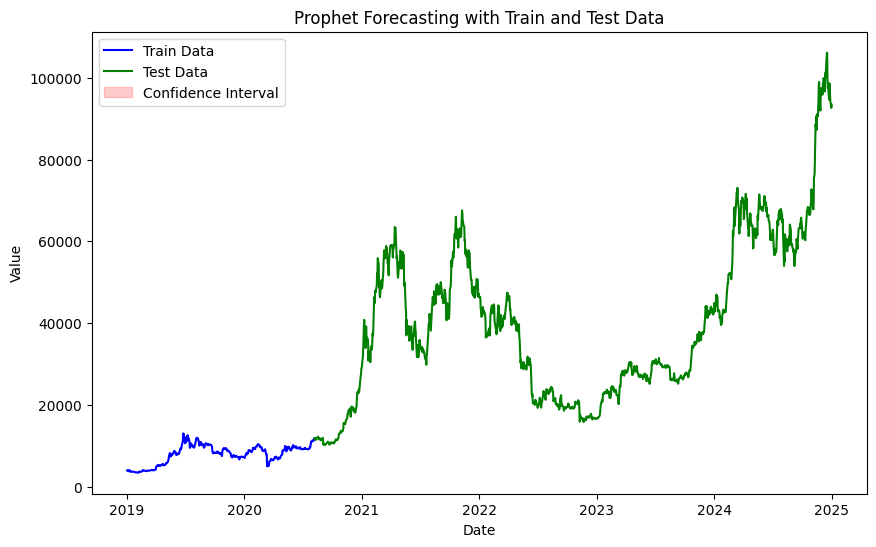

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

In [41]:
# Create the figure and axes outside the loop
fig, ax = plt.subplots(figsize=(10, 6))

# Enable interactive mode
#plt.ion()

show_prediction(data_train, data_test, fig, ax)
while len(data_test)>0:
    # data_train = pd.concat([data_train, data_test.iloc[[:20]]], axis = 0)
    data_train = pd.concat([data_train, data_test.iloc[:20]], axis = 0)

    data_test = data_test.iloc[20:]
    # Predict future values
    #data_forcasting = prophet_model.predict(data_test[['ds', 'Close_S&P500']])

    # Extract the forecasted values and dates
    #forecasted_values = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    show_prediction(data_train, data_test, fig, ax)
    plt.pause(0.5) 


# Disable interactive mode after the loop ends



In [38]:
# Print forecast data (optional)
print(forecast.tail())

            ds         trend    yhat_lower    yhat_upper  trend_lower  \
297 2024-12-24  14690.486893  37931.266591  72176.517537  -754.437673   
298 2024-12-26  14691.716972  37756.491709  72736.406007  -855.539465   
299 2024-12-27  14692.332012  36989.147627  72020.063765  -957.256296   
300 2024-12-30  14694.177130  36366.736891  71385.329271 -1057.743049   
301 2024-12-31  14694.792170  36182.756524  71346.405537 -1159.459881   

      trend_upper  Close_S&P500  Close_S&P500_lower  Close_S&P500_upper  \
297  31559.345155  40525.797900        40525.797900        40525.797900   
298  31644.226581  40482.907609        40482.907609        40482.907609   
299  31728.492968  39314.459146        39314.459146        39314.459146   
300  31813.989434  38195.901204        38195.901204        38195.901204   
301  31898.255821  37752.852529        37752.852529        37752.852529   

     additive_terms  ...       weekly  weekly_lower  weekly_upper  \
297    39891.984224  ...  2742.935344   2

In [1]:
from pycoingecko import CoinGeckoAPI
import time

In [2]:
# Initialize the CoinGecko client
cg = CoinGeckoAPI()

In [4]:
def get_real_time_btc_price():
    while True:
        # Fetch the current Bitcoin price in USD
        btc_data = cg.get_price(ids='bitcoin', vs_currencies='usd')
        btc_price = btc_data['bitcoin']['usd']
        print(f"BTC/USDT Price: {btc_price}")
        
        # Wait for 1 second before fetching the price again
        time.sleep(2)



In [5]:
# Start streaming real-time BTC price
get_real_time_btc_price()

BTC/USDT Price: 99622
BTC/USDT Price: 99622
BTC/USDT Price: 99622
BTC/USDT Price: 99622


KeyboardInterrupt: 